In [1]:
from logLikeli import logLike

import numpy as np
import pymaster as nmt
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt 
import imp
import camb

from astropy.io import fits as fits

from scipy.linalg import sqrtm

from numpy import linalg as LA
%matplotlib inline

In [2]:
import utils

In [161]:
from utils import Marray_EEfirst as Marray
from utils import Minv as Minv
from utils import evaluateLikelihood as evaluateL
from utils import combine_ps as combine_ps

In [4]:
import dynesty
from dynesty import plotting as dyplot
## import planck function 
from pysm.common import B as pf
from Fg_template import sync_ps, dust_ps

In [5]:
from pysm.common import convert_units

In [22]:
from dynesty import utils as dyfunc 

In [6]:
from multiprocessing import Pool, cpu_count

In [157]:
import cmath

In [159]:
cmath.sqrt(-1)

1j

## data

In [94]:
A_d_RJ = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/dust_template_353_BB_RJ.npy')
dust_dl_RJ = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/dust_BB_cross_fre_1p56_from_RJ.npy')

A_s_RJ = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/sync_template_30_BB_RJ.npy')
sync_dl_RJ = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/sync_BB_cross_fre_n3p0_from_RJ.npy')

In [261]:
path = '/fnx/jianyao/Likelihood_data/Bandpowers/0710_2fre_Ali_real_fore_and_noise'

cl_f_all_ali = np.load('%s/cl_f_all.npy'%path); cl_f_ali = np.mean(cl_f_all_ali, axis = 0)

## to include the dust and sync cross ps into the fiducial ps. Only BB for now; 2020.07.13
# cl_f_all_ali[:,2] +=  sync_dl_RJ + dust_dl_RJ #

cl_hat_all_ali = np.load('%s/cl_hat_fore_all.npy'%path) 
# cl_hat_0_ali = cl_hat_all_ali[10]

# cl_hat_all_ali = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0710_2fre_Ali_real_fore_and_noise/cl_hat_r0_all.npy')

nl_all_ali = np.load('%s/nl_all.npy'%path)
nl_mean_ali = np.mean(nl_all_ali, axis = 0) ## EE EB BB

In [126]:
cl_camb = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0627_2fre_fullsky/cl_camb_BB_2fre.npy')
cl_th_BB_ali = cl_camb + nl_mean_ali[2]

In [9]:
lensingB = utils.Gencl(r = 0, raw_cl = True) ## only lensing BB; TT EE BB TE

bb_05 = utils.Gencl(r = 0.05, raw_cl = True, tensorBB_only=True) ##only tensor BB; ## 

In [60]:
cmb_bb = lensingB[2] + bb_05

b.bin_cell(cmb_bb[0:nmtlmax+1])

In [13]:
nside = 128
nmtlmax = 201
lmin = 2
lmax = 1521

Nf = 2

b = nmt.NmtBin(nside, nlb=20, is_Dell=True, lmax=nmtlmax)
leff = b.get_effective_ells()
lbin = len(leff)
b_ind = np.arange(1,lbin+1)

In [162]:
def combine_ps(r):
    
    '''
    Combine the tensor bb and lensing bb power spectrum of CMB.
    '''
    
    bb_tensor = bb_05[0:nmtlmax+1]*r/0.05 

    bb_camb = bb_tensor + lensingB[2][0:nmtlmax+1] ## tensor BB + lensing BB 

    cl_th_i = b.bin_cell(bb_camb[0:nmtlmax+1])  ## theoretical bandpower, use simple window function
    cl_th_test = np.ones((lbin, Nf, Nf));  ## BB cross power spectra
    for ell in range(lbin):
        cl_th_test[ell] *= cl_th_i[ell]
        
    return cl_th_test

## Method

### decompose 

In [155]:
alpha_s = -1.2; alpha_d = -0.5; beta_s = -3.0; beta_d = 1.558; epsilon = 0.3;

Cl_test = combine_ps(0) + nl_mean_ali[2] + sync_ps(A_s_RJ[3], leff, alpha_s, beta_s) + dust_ps(A_d_RJ[3], leff, alpha_d, beta_d) \
        + corre_fore(epsilon, A_d_RJ[3], A_s_RJ[3], leff, alpha_s, alpha_d, beta_s, beta_d);

In [163]:
lbin

10

In [166]:
Cl_test.shape

(10, 2, 2)

In [226]:
def vecp(mat):
    '''
    This returns the unique elements of a symmetric matrix 
    '''

    dim = mat.shape[0]
    
    vec = np.zeros(int(dim*(dim+1)/2), dtype = np.complex)
    counter = 0
    for k in range(0,dim):
        vec[counter:counter+dim-k] = np.diag(mat,k)
        
        counter = counter + dim - k

    return vec

In [256]:
nf_ind = int(Nf*(Nf+1)/2)
    
Xall = np.ones(lbin*nf_ind, dtype = np.complex)    
for l in range(lbin):

    cl_f_12 = sqrtm(cl_f_ali[2][l])
    cl_inv = LA.pinv(Cl_test[l])
    cl_inv_12= sqrtm(cl_inv)

    res = np.dot(cl_inv_12, np.dot(cl_hat_all_ali[0][2][l], cl_inv_12))

    [d, u] = LA.eigh(res)
#     d = np.diag(d)  # noticed that python returns the eigenvalues as a vector, not a matrix
  
    gd = np.ones(Nf, dtype = np.complex);
    for i in range(Nf):
        
        gd[i] = np.sign(d[i] - 1) * cmath.sqrt(2 * (d[i] - np.log(d[i]) - 100))
        
    gd = np.diag(gd);
        
    # Argument of vecp in equation 8; multiplying from right to left     
    X = np.dot(np.transpose(u), cl_f_12)
    X = np.dot(gd, X)
    X = np.dot(u, X)
    X = np.dot(cl_f_12, X)
    # This is the vector of equation 7  
    Xall[l*nf_ind:(l+1)*nf_ind] = vecp(X)

Xa = np.matrix(Xall)

In [257]:
Xa*LA.inv(LogL.Cov)*np.transpose(Xa)

matrix([[-1839843.90914143+0.j]])

In [259]:
gd

array([[-0.-14.07119596j,  0. +0.j        ],
       [ 0. +0.j        ,  0.+14.07118426j]])

In [219]:
gd

array([[-0.-14.14208456j,  0. +0.j        ],
       [ 0. +0.j        ,  0.+14.14207292j]])

In [232]:
vecp(X)

array([0.-0.32121034j, 0.+0.21141468j, 0.-0.08981704j])

In [ ]:
LogL.run(cl_hat=cl_hat_all_ali[0][2], cl_th=Cl_test, sbin=1)

### init logL function 

In [160]:
imp.reload(utils)

<module 'utils' from '/home/jianyao/Likelihood/utils.py'>

In [148]:
from utils import testL as testL

In [149]:
LogL = logLike(2,10) 

 ## calculate logL.cl_f; logL.Cov  

LogL.M(cl_f_all = cl_f_all_ali, SamNum=500)

In [132]:
SamNum = 500

In [252]:
LogL.run(cl_hat=cl_hat_all_ali[0][2], cl_th=Cl_test, sbin=0)

-46.02194294052543

In [14]:
cl_hat_all_ali.shape

(500, 3, 10, 2, 2)

In [17]:
sig1 = [0.16, 0.5, 0.84]; sig2 = [0.021, 0.5, 0.979];

### test input r=0 

In [83]:
npara = 3; Nsim = 30

def prior(cube):
    
    r = cube[0]*0.2 - 0.1
    beta_s = cube[1]*2 - 4## from -4 to -2
    beta_d = cube[2]*0.4 + 1.4 ## from 1.4 to 1.8

    return [r, beta_s, beta_d]

Mean = np.zeros((Nsim,npara)); Samples = np.zeros((Nsim, npara)); Weights = np.zeros(Nsim);
for n in range(Nsim):
    
    cl_hat_fore_ali = cl_hat_all_ali[n][2]
      
    def log_likelihood(cube, subtract = False):
        r_i = cube[0];
        beta_s = cube[1];
        beta_d = cube[2];

        bb_tensor = bb_05[0:nmtlmax+1]*r_i/0.05 

        bb_camb = bb_tensor + lensingB[2][0:nmtlmax+1] ## tensor BB + lensing BB 

        cl_th_i = b.bin_cell(bb_camb[0:nmtlmax+1])  ## theoretical bandpower 
        cl_th_test = np.ones((lbin, Nf, Nf));  ## BB cross power spectra
        for ell in range(lbin):
            cl_th_test[ell] *= cl_th_i[ell]

        # add Noise bias N_l to expectation values.########################## Noise level
        C_l = cl_th_test + nl_mean_ali[2] + sync_ps(A_s_RJ, beta_s, 10) + dust_ps(A_d_RJ, beta_d, 10);
        logL =LogL.run(cl_hat=(cl_hat_fore_ali) , cl_th = C_l, sbin=1);   

        return np.real(logL)
    
    with Pool(cpu_count()-1) as executor:
        
        sampler = dynesty.NestedSampler(log_likelihood, prior, npara, nlive=400, pool=executor, queue_size=cpu_count(), bootstrap = 0)
        sampler.run_nested(dlogz = 0.1)
        results = sampler.results
    
    if n == 0 : 
        samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
    
    else: 
        _samples, _weights = results.samples, np.exp(results.logwt - results.logz[-1])
        samples = np.r_[samples, _samples];
        weights = np.r_[weights, _weights]
    
#     mean, cov = dyfunc.mean_and_cov(samples, weights) 
    
#     Mean[n] = mean

In [56]:
resamples = dyfunc.resample_equal(samples, weights)

print(np.mean(resamples[:,0]))
print(np.std(resamples[:,0]))

print(np.mean(resamples[:,1]))
print(np.std(resamples[:,1]))

print(np.mean(resamples[:,2]))
print(np.std(resamples[:,2]))

0.001766507136861076
0.006820990723935475
-2.9903406149686047
0.0786657363610382
1.549191064673645
0.008951244490172764


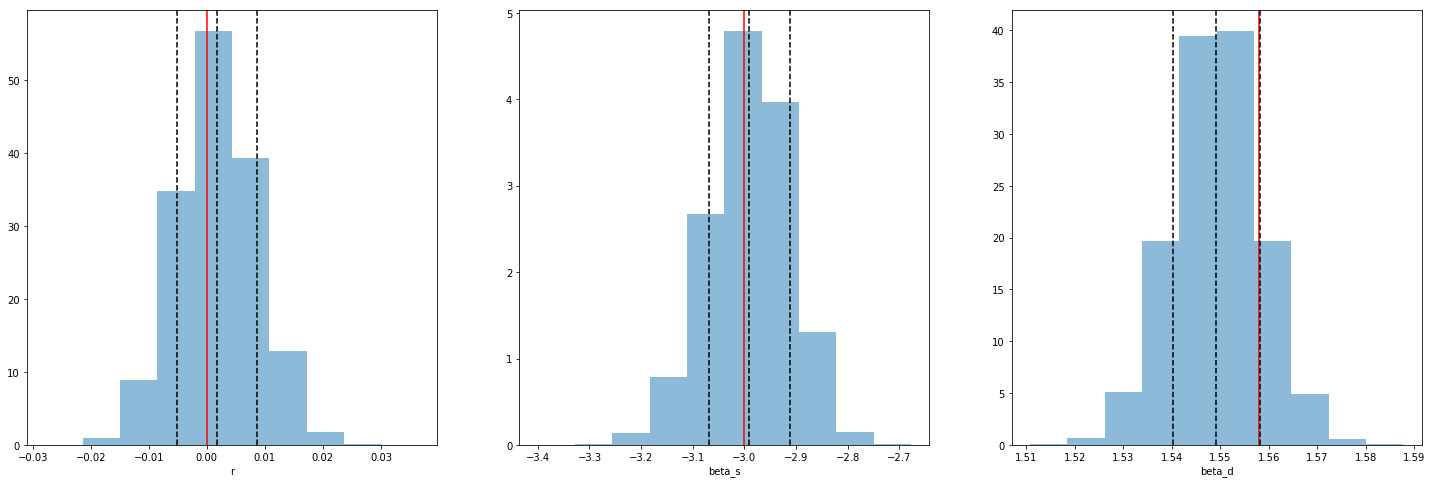

In [58]:
truth = [0, -3.0, 1.558];

fig, axes = plt.subplots(1,npara, figsize = (25,8))

paras = ['r', 'beta_s', 'beta_d']
for m in range(npara):
    
    axes[m].hist(resamples[:,m], density=True, alpha = 0.5); 
    axes[m].axvline(truth[m], c = 'r')
    axes[m].axvline(np.mean(resamples[:,m]),c = 'k', ls = '--')
    axes[m].axvline(np.mean(resamples[:,m] + np.std(resamples[:,m])),c = 'k', ls = '--')
    axes[m].axvline(np.mean(resamples[:,m] - np.std(resamples[:,m])),c = 'k', ls = '--')
    axes[m].set_xlabel(r'%s'%paras[m])


(<Figure size 1080x720 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f56f8307908>,
       dtype=object))

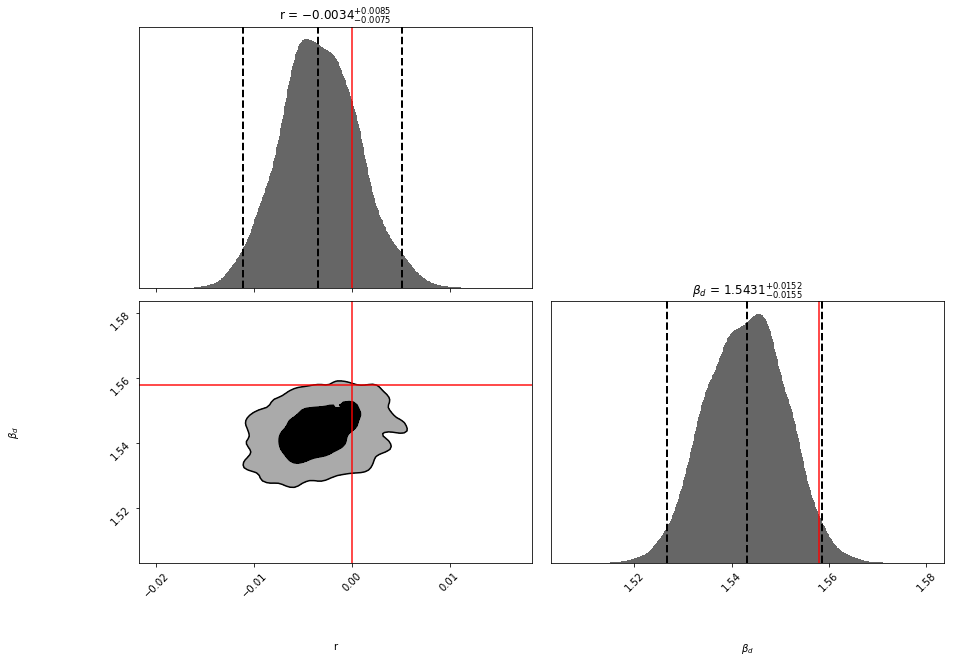

In [30]:
labels = ['r',r'$\beta_d$']; npara = 2
fig, axes = plt.subplots(npara,npara, figsize=(15, 10))
axes = axes.reshape((npara,npara))

truth = [0, 1.558]

dyplot.cornerplot(results,  truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                 labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85


### complex foreground model

#### model test

In [122]:
dl_alpha = dust_ps(A_d_RJ[3], leff, -0.5, 1.558)
sl_alpha = sync_ps(A_s_RJ[3], leff, -1.2, -3.0)

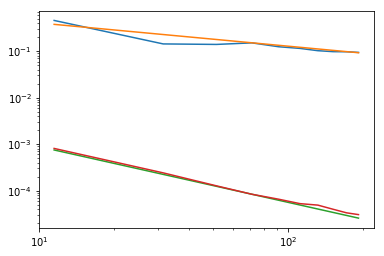

In [123]:
plt.loglog(leff, dust_dl_RJ[:,1,1])
plt.loglog(leff, dl_alpha[:,1,1])

plt.loglog(leff, sl_alpha[:,1,1])
plt.loglog(leff, sync_dl_RJ[:,1,1])

In [72]:
def dust_ps(A_d, ells, alpha_d, beta_d, nu = np.array([95, 150]), nu0 = 353, T_d = 19.6):
    
    '''
    Input
    -------------------------
    A_d : PS template at reference frequency at around 80; input in **uK_RJ** units.
    ells : exact ls for each l-bin; 
    beta_d : spectra index to be determined from likelihood analyis.
    
    Output
    -------------------------
    Cross power spectra for dust component, output in **uK_CMB** units.
    
    '''
    Nf = len(nu); lbin = len(ells)
    coeff = convert_units("uK_RJ", "uK_CMB", nu);
    dl = np.ones((lbin, Nf, Nf));
    
    b0 = pf(nu0, T_d); b12 = pf(nu, T_d);    
    
    factors = np.ones((Nf, Nf))
    for i in range(Nf):
        for j in range(Nf):
            factors[i][j] = b12[i]*b12[j]/b0**2
    
    for ell in range(lbin):
        
        for i in range(Nf): 
            for j in range(Nf):
                
                dl[ell, i,j] = A_d*(ells[ell]/71.5)**alpha_d*(nu[i]*nu[j]/nu0**2)**(beta_d - 2)*factors[i,j]*coeff[i]*coeff[j]
                
    return dl


def sync_ps(A_s, ells, alpha_s, beta_s, nu = np.array([95, 150]), nu0 = 30):
    
    '''
    Input
    -------------------------
    A_s : PS template at reference frequency at each lbin; input in **uK_RJ** units.
    ells : exact ls for each l-bin; 
    
    beta_s : spectra index to be determined from likelihood analyis.
    
    Output
    -------------------------
    Cross power spectra for dust component, output in **uK_CMB** units.
    
    '''    
    
    Nf = len(nu); lbin = len(ells)
    coeff = convert_units("uK_RJ", "uK_CMB", nu);
    sl = np.ones((lbin, Nf, Nf));
    
    for ell in range(lbin):
        
        for i in range(Nf): 
            for j in range(Nf):
                sl[ell, i, j] = A_s*(ells[ell]/71.5)**alpha_s*(nu[i]*nu[j]/nu0**2)**(beta_s)*coeff[i]*coeff[j] ;
                
    return sl

def corre_fore(epsilon, A_d, A_s, ells, alpha_s, alpha_d, beta_s, beta_d, nu = np.array([95, 150]), nu_s0 = 30, nu_d0 = 353):
    
    Nf = len(nu); lbin = len(ells)
    coeff = convert_units("uK_RJ", "uK_CMB", nu);
    
    fl = np.ones((lbin, Nf, Nf));
    
    f = epsilon*np.sqrt(A_s*A_d); 
    
    for ell in range(lbin):
        for i in range(Nf): 
            for j in range(Nf):
                
                fl[ell, i, j] =f*(ells[ell]/71.5)**((alpha_s + alpha_d)/2)*(f_d(nu[i], beta_d)*f_s(nu[j], beta_s) + f_d(nu[j], beta_d)*f_s(nu[i], beta_s))*coeff[i]*coeff[j]  
                                                                            
    return fl

def f_d(nu, beta_d, nu0 = 353, T_d = 19.6):
    
    return (nu/nu0)**(beta_d - 2)*pf(nu, T_d)/pf(nu0, T_d)
    
def f_s(nu, beta_s, nu0 = 30):
    
    return (nu/nu0)**beta_s

#### likelihood

In [91]:
A_s_RJ[3]

0.43429827347145034

In [97]:
A_d_RJ[3]

0.4190583022143424

In [292]:
npara = 8; Nsim = 1;

def prior(cube):
    
    r = cube[0]*0.1
    beta_s = cube[1]*2 - 4## from -4 to -2
    beta_d = cube[2]*0.4 + 1.4 ## from 1.4 to 1.8
    
    # -1.2
    alpha_s = cube[3]*0.6 - 1.5
    
    #-0.5
    alpha_d = cube[4]*0.6 - 0.8
    
    epsilon = cube[5]*2 - 1
    
    A_s = cube[6]; A_d = cube[7] ## from 0 to 1; in uK_RJ units
    
    return [r, beta_s, beta_d, alpha_s, alpha_d, epsilon, A_s, A_d]

Mean = np.zeros((Nsim,npara)); Samples = np.zeros((Nsim, npara)); Weights = np.zeros(Nsim);

for n in range(Nsim):
    
    cl_hat_fore_ali = cl_hat_all_ali[n][2]
      
    def log_likelihood(cube, subtract = False):
        
        r_i = cube[0];
        beta_s = cube[1]; beta_d = cube[2];
        
        alpha_s = cube[3]; alpha_d = cube[4]; 
        
        epsilon = cube[5];
        
        A_s = cube[6]; A_d = cube[7]

        cl_th_test = combine_ps(r_i)  ## combine the tensor bb and lensing bb

        # add Noise bias N_l to expectation values.########################## Noise level
        C_l = cl_th_test + nl_mean_ali[2] + sync_ps(A_s, leff, alpha_s, beta_s) + dust_ps(A_d, leff, alpha_d, beta_d) \
        + corre_fore(epsilon, A_d, A_s, leff, alpha_s, alpha_d, beta_s, beta_d);
        
        logL =LogL.run(cl_hat=(cl_hat_fore_ali) , cl_th = C_l, sbin=1);   

        return np.real(logL)
    
    with Pool(cpu_count()-1) as executor:
        
        sampler = dynesty.NestedSampler(log_likelihood, prior, npara, nlive=400, pool=executor, queue_size=cpu_count(), bootstrap = 0)
        sampler.run_nested()
        results = sampler.results

#     if n == 0 : 
#         samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
    
#     else: 
#         _samples, _weights = results.samples, np.exp(results.logwt - results.logz[-1])
#         samples = np.r_[samples, _samples];
#         weights = np.r_[weights, _weights];

5725it [00:34, 163.58it/s, +400 | bound: 27 | nc: 1 | ncall: 30806 | eff(%): 19.882 | loglstar:   -inf < -11.223 <    inf | logz: -24.632 +/-  0.256 | dlogz:  0.001 >  0.409]


In [276]:
resamples = dyfunc.resample_equal(samples, weights)

# print(np.mean(resamples[:,0]))
# print(np.std(resamples[:,0]))

# print(np.mean(resamples[:,1]))
# print(np.std(resamples[:,1]))

# print(np.mean(resamples[:,2]))
# print(np.std(resamples[:,2]))

/home/jianyao/anaconda3/lib/python3.7/site-packages/dynesty/utils.py:163: UserWarning: Weights do not sum to 1 and have been renormalized.
  warnings.warn("Weights do not sum to 1 and have been renormalized.")


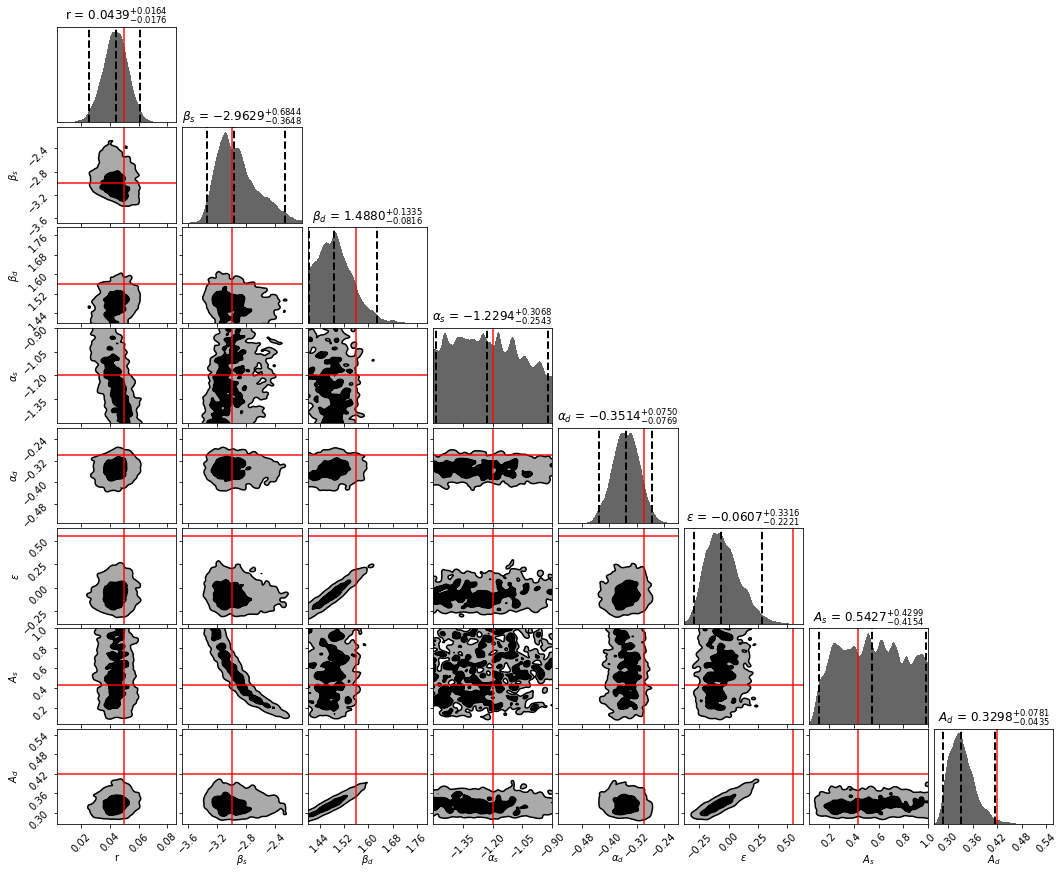

In [303]:
labels = ['r',r'$\beta_s$', r'$\beta_d$', r'$\alpha_s$', r'$\alpha_d$', r'$\epsilon$', r'$A_s$', r'$A_d$']; 
fig, axes = plt.subplots(npara,npara, figsize=(15, 12))
axes = axes.reshape((npara,npara))

truth = [0.05, -3.0, 1.56, -1.2, -0.3,  0.55,0.434, 0.419]

fg, ax = dyplot.cornerplot(results,  truths=truth, title_fmt='.4f', show_titles=True,
                 labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85], fig = (fig, axes)) #0.1, 0.4, 0.65, 0.85

plt.savefig('./fig_results/dynesty/0724_contour_7parameters.pdf', format = 'pdf')

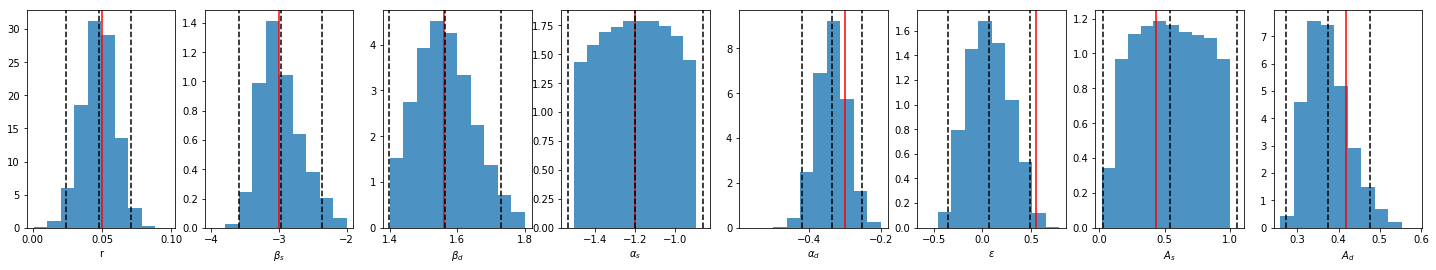

In [304]:

fig, axes = plt.subplots(1,npara, figsize = (25,4))

for m in range(npara):
    
    axes[m].hist(resamples[:,m], density=True, alpha = 0.8); 
    axes[m].axvline(truth[m], c = 'r')
    axes[m].axvline(np.mean(resamples[:,m]),c = 'k', ls = '--')
    axes[m].axvline(np.mean(resamples[:,m] +2*np.std(resamples[:,m])),c = 'k', ls = '--')
    axes[m].axvline(np.mean(resamples[:,m] - 2*np.std(resamples[:,m])),c = 'k', ls = '--')
    axes[m].set_xlabel(r'%s'%labels[m])


plt.savefig('./fig_results/dynesty/0724_constraints_on_7parameters_2sigma_range.pdf', format = 'pdf')

In [298]:
np.std(resamples[:,0])

0.011719674514914043